In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, r2_score
from six import StringIO
import pydotplus
from IPython.display import Image

In [8]:
data = pd.read_csv('data/OJ.csv', index_col=0).reset_index(drop=True).drop(columns='Store7')
data['Purchase_MM'] = [1 if x == 'MM' else 0 for x in data['Purchase']]
data

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE,Purchase_MM
0,CH,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,0.000000,0.000000,0.24,1,0
1,CH,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,0.150754,0.000000,0.24,1,0
2,CH,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,0.000000,0.091398,0.23,1,0
3,MM,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,0.000000,0.000000,0.00,1,1
4,CH,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,0.000000,0.000000,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,CH,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,0.000000,0.053763,0.23,0,0
1066,CH,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,0.000000,0.000000,0.32,0,0
1067,MM,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,0.000000,0.000000,0.32,0,1
1068,CH,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,0.112676,0.000000,0.27,0,0


In [12]:
X = data.drop(columns=['Purchase', 'Purchase_MM'])
y = data['Purchase_MM']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=800, shuffle=True, random_state=1)

In [15]:
# Create function classification
clf_tree = DecisionTreeClassifier(random_state=1, max_leaf_nodes=8)
clf_tree.fit(X_train, y_train)

# Return training accuracy
print('Accuracy: {:.4f}.\n'.format(clf_tree.score(X_train, y_train)))
print('Number of Leaves: {}.\n'.format(clf_tree.tree_.n_leaves))

Accuracy: 0.8475.

Number of Leaves: 8.



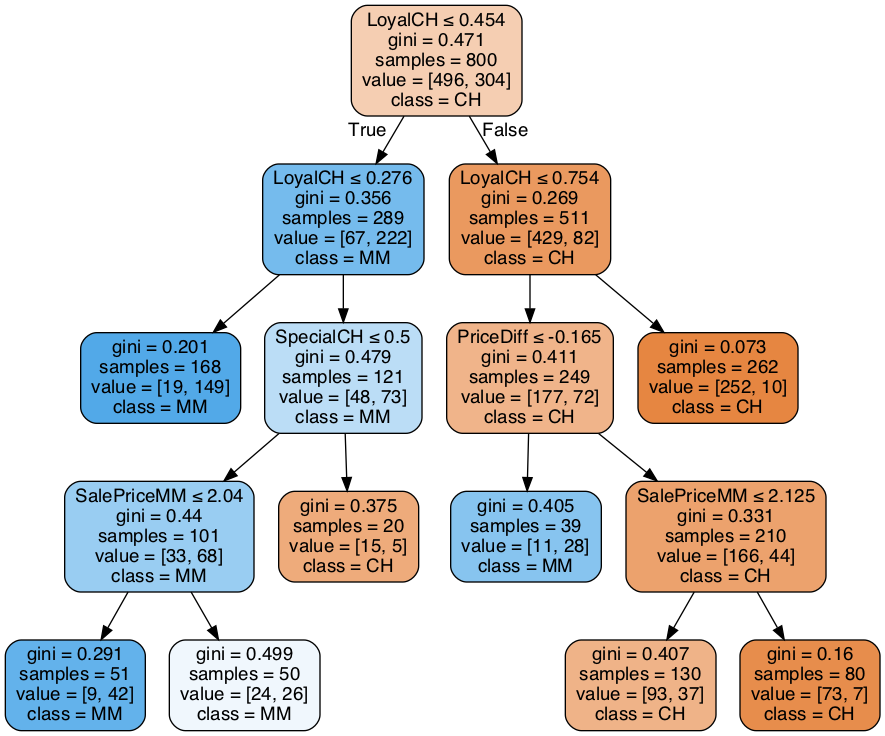

In [16]:
# Create Tree Chart
dot_data = StringIO()

export_graphviz(clf_tree, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=X.columns, class_names=['CH', 'MM'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In [17]:
# Calculate test error on test set
y_pred = clf_tree.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
clf_pred_result = pd.DataFrame(matrix, index=['CH', 'MM'], columns=['Pred CH', 'Pred MM'])

# Print result
print('Accuracy: {:.4f}'.format((matrix[0][0]+ matrix[1][1])/(matrix.sum())))
print('')
print(clf_pred_result)
print('')
print(classification_report(y_test, y_pred))

Accuracy: 0.8185

    Pred CH  Pred MM
CH      139       18
MM       31       82

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       157
           1       0.82      0.73      0.77       113

    accuracy                           0.82       270
   macro avg       0.82      0.81      0.81       270
weighted avg       0.82      0.82      0.82       270



In [18]:
# Seem a good prediction result compare to training accuracy

In [36]:
# Use Crossvalidation to find optimal max leaves
def display_clf_tree_pruning_cv_result_leaves(leaves_range, X, y):

    cv = KFold(n_splits=10, shuffle=True, random_state=1)

    # Create data
    train_accuracy = []
    test_accuracy = []
    for i in leaves_range:

        # Create a list model due to changes of alpha
        clf_tree = DecisionTreeClassifier(max_leaf_nodes=i, random_state=1)
        score = cross_validate(clf_tree, X, y, cv=cv, scoring=('accuracy', 'f1'), return_train_score=True)

        # Append result mean r2, mse
        train_accuracy.append(np.mean(score['train_accuracy']))
        test_accuracy.append(np.mean(score['test_accuracy']))

    # Wrap to numpy array to for easy to manipulate
    train_accuracy = np.array(train_accuracy)
    test_accuracy = np.array(test_accuracy)

    k = test_accuracy.argmax()

    # Start plot data
    plt.figure(figsize=(16,6))

    plt.plot(leaves_range, train_accuracy, label='train accuracy')
    plt.plot(leaves_range, test_accuracy, label='test accuracy')
    plt.plot(leaves_range[k], test_accuracy[k], 'ro', label='Max test accuracy: {:.4f} at max {} leaves'.format(test_accuracy[k], leaves_range[k]))
    plt.xlabel('Max Leaf nodes')
    plt.ylabel('Accuracy')
    plt.xticks(leaves_range)
    plt.legend()
    plt.title('Accuracy test set')

    plt.show()

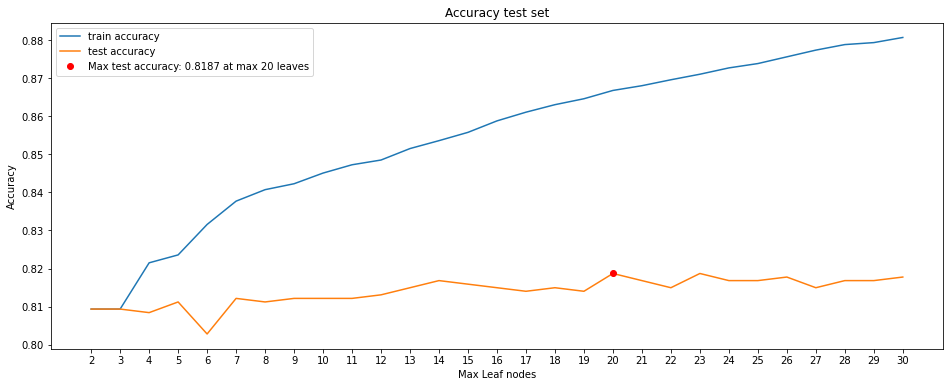

In [37]:
leaves_range = np.arange(2,31)
display_clf_tree_pruning_cv_result_leaves(leaves_range, X, y)

In [39]:
# It seem that 20 terminal nodes is best for cv Accuracy
# This is not a prunning tree because 20 > 8 original

In [40]:
# Create function classification
clf_tree = DecisionTreeClassifier(random_state=1, max_leaf_nodes=20)
clf_tree.fit(X_train, y_train)

# Return training accuracy
print('Accuracy: {:.4f}.\n'.format(clf_tree.score(X_train, y_train)))
print('Number of Leaves: {}.\n'.format(clf_tree.tree_.n_leaves))

# Calculate test error on test set
y_pred = clf_tree.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
clf_pred_result = pd.DataFrame(matrix, index=['CH', 'MM'], columns=['Pred CH', 'Pred MM'])

# Print result
print('Accuracy: {:.4f}'.format((matrix[0][0]+ matrix[1][1])/(matrix.sum())))
print('')
print(clf_pred_result)
print('')
print(classification_report(y_test, y_pred))

Accuracy: 0.8750.

Number of Leaves: 20.

Accuracy: 0.8000

    Pred CH  Pred MM
CH      138       19
MM       35       78

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       157
           1       0.80      0.69      0.74       113

    accuracy                           0.80       270
   macro avg       0.80      0.78      0.79       270
weighted avg       0.80      0.80      0.80       270



In [41]:
# Result of 20 leaves not improve the test accuracy

In [57]:
# Create function classification
clf_tree = DecisionTreeClassifier(random_state=1, max_leaf_nodes=5)
clf_tree.fit(X_train, y_train)

# Return training accuracy
print('Accuracy: {:.4f}.\n'.format(clf_tree.score(X_train, y_train)))
print('Number of Leaves: {}.\n'.format(clf_tree.tree_.n_leaves))

# Calculate test error on test set
y_pred = clf_tree.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
clf_pred_result = pd.DataFrame(matrix, index=['CH', 'MM'], columns=['Pred CH', 'Pred MM'])

# Print result
print('Accuracy: {:.4f}'.format((matrix[0][0]+ matrix[1][1])/(matrix.sum())))
print('')
print(clf_pred_result)
print('')
print(classification_report(y_test, y_pred))

Accuracy: 0.8350.

Number of Leaves: 5.

Accuracy: 0.8185

    Pred CH  Pred MM
CH      139       18
MM       31       82

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       157
           1       0.82      0.73      0.77       113

    accuracy                           0.82       270
   macro avg       0.82      0.81      0.81       270
weighted avg       0.82      0.82      0.82       270



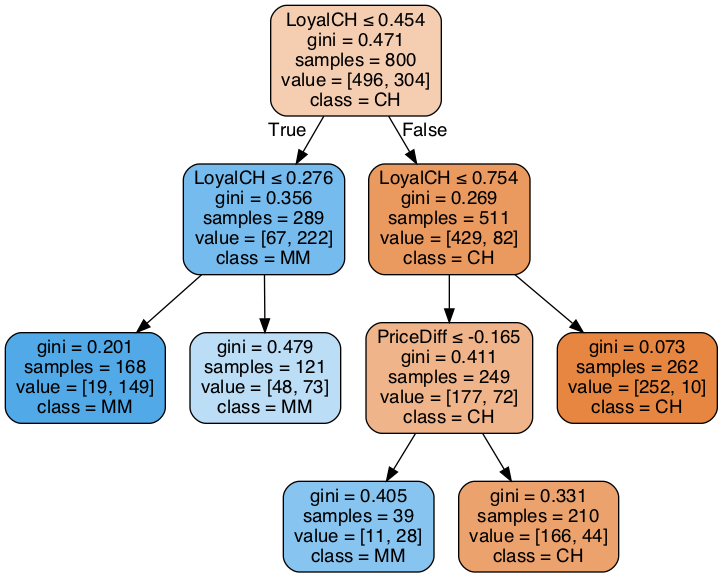

In [44]:
# Result of 5 leaves same as with 8 nodes
# Prunning tree 5 leaves work
# Create Tree Chart
dot_data = StringIO()

export_graphviz(clf_tree, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=X.columns, class_names=['CH', 'MM'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In [49]:
# Try to prunning by ccp_alpha
def display_clf_tree_pruning_cv_result(ccp_alphas, X, y):

    global alpha_optimal

    cv = KFold(n_splits=10, shuffle=True, random_state=1)

    # Create data
    train_accuracy = []
    test_accuracy = []
    for ccp_alpha in ccp_alphas:

        # Create a list model due to changes of alpha
        clf_tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=1)
        score = cross_validate(clf_tree, X, y, cv=cv, scoring=('accuracy', 'f1'), return_train_score=True)

        # Append result mean accuracy, mse
        train_accuracy.append(np.mean(score['train_accuracy']))
        test_accuracy.append(np.mean(score['test_accuracy']))

    # Wrap to numpy array to for easy to manipulate
    train_accuracy = np.array(train_accuracy)
    test_accuracy = np.array(test_accuracy)
    
    k = test_accuracy.argmax()
    k_f_bound = len(test_accuracy)-1-k
    k_f = k + k_f_bound
    k_b = k - k

    alpha_optimal = ccp_alphas[k]

    optimal_clf_tree = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alphas[k]).fit(X, y)
    leaves = optimal_clf_tree.tree_.n_leaves
    # Start plot data
    plt.figure(figsize=(8,6))

    plt.plot(ccp_alphas, train_accuracy, label='train Accuracy')
    plt.plot(ccp_alphas, test_accuracy, label='test R2')
    plt.plot(ccp_alphas[k], test_accuracy[k], 'ro', label='Max test Accuracy: {:.4f} at alpha: {:.4f}, {} leaves'.format(test_accuracy[k], ccp_alphas[k], leaves))
    plt.xlabel('Alphas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy on test set')

    plt.show()

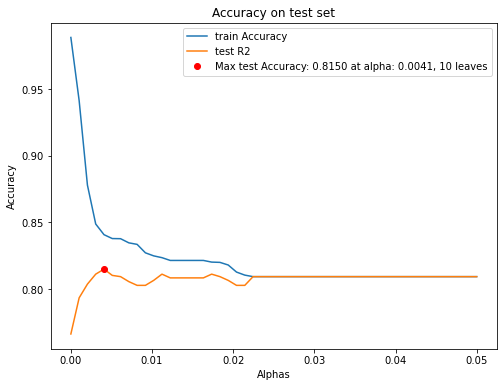

In [51]:
ccp_alphas_cv = np.linspace(0,0.05,50)
alpha_optimal = 0
display_clf_tree_pruning_cv_result(ccp_alphas_cv, X, y)

In [52]:
alpha_optimal

0.004081632653061225

In [53]:
# Create function classification
clf_tree = DecisionTreeClassifier(random_state=1, ccp_alpha=alpha_optimal)
clf_tree.fit(X_train, y_train)

# Return training accuracy
print('Accuracy: {:.4f}.\n'.format(clf_tree.score(X_train, y_train)))
print('Number of Leaves: {}.\n'.format(clf_tree.tree_.n_leaves))

# Calculate test error on test set
y_pred = clf_tree.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
clf_pred_result = pd.DataFrame(matrix, index=['CH', 'MM'], columns=['Pred CH', 'Pred MM'])

# Print result
print('Accuracy: {:.4f}'.format((matrix[0][0]+ matrix[1][1])/(matrix.sum())))
print('')
print(clf_pred_result)
print('')
print(classification_report(y_test, y_pred))

Accuracy: 0.8512.

Number of Leaves: 9.

Accuracy: 0.8111

    Pred CH  Pred MM
CH      139       18
MM       33       80

              precision    recall  f1-score   support

           0       0.81      0.89      0.84       157
           1       0.82      0.71      0.76       113

    accuracy                           0.81       270
   macro avg       0.81      0.80      0.80       270
weighted avg       0.81      0.81      0.81       270



In [55]:
# Prunning with alpha also 9 node and result nearly the same
# If we want to improve accuracy, we need bagging, random forests or boosting